In [1]:
import copy
import json
import os
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np

# shap displays NumbaDeprecationWarning when importing -- supress them
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

import shap
import torch
from torch import Tensor, sigmoid

# logging.basicConfig(level=logging.INFO)

# correct path to repository root
if os.path.basename(os.getcwd()) == "scripts":
    REPOSITORY_ROOT = os.path.join(os.getcwd(), "..")
elif os.path.basename(os.getcwd()) == "adversarial":
    REPOSITORY_ROOT = os.path.join(os.getcwd(), "..", "..")
else:
    REPOSITORY_ROOT = os.getcwd()
sys.path.append(REPOSITORY_ROOT)

from nebula import PEDynamicFeatureExtractor
from nebula.models.attention import TransformerEncoderChunksOptionalEmbedding
from nebula.preprocessing import JSONTokenizerNaive

from nebula.misc import fix_random_seed
fix_random_seed(0)


def compute_score(llm, x, verbose=True):
    logit = llm(x)
    prob = sigmoid(logit)
    if verbose:
        print(f"\n[!!!] Probability of being malicious: {prob.item():.3f} | Logit: {logit.item():.3f}")
    return prob.item()


def load_tokenizer():
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects",
                           "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)

    tokenizer = JSONTokenizerNaive(
        vocab_size=len(vocab),
        seq_len=512,
        vocab=vocab
    )
    return tokenizer

def tokenize_sample(report_path, encode=True):
    extractor = PEDynamicFeatureExtractor()
    filtered_report = extractor.filter_and_normalize_report(report_path)
    tokenizer = load_tokenizer()
    tokenized_report = tokenizer.tokenize(filtered_report)
    if encode:
        encoded_report = tokenizer.encode(tokenized_report, pad=True, tokenize=False)
        x = Tensor(encoded_report).long()
        return x
    else:
        return tokenized_report


def embed(llm_model, report):
    src = tokenize_sample(report)
    return torch.cat(llm_model.embed(llm_model.split(src)), dim=1)


def plot_shap_values(shap_values: np.ndarray, name: str):
    shap_values = shap_values.mean(axis=2)
    pos_idx = shap_values[0] >= 0
    neg_index = shap_values[0] < 0
    pos_shap = copy.deepcopy(shap_values)[0]
    pos_shap[neg_index] = 0
    neg_shap = copy.deepcopy(shap_values)[0]
    neg_shap[pos_idx] = 0
    x = range(512)
    plt.bar(x, pos_shap)
    plt.bar(x, neg_shap)
    plt.title(name)
    plt.show()


def load_model(skip_embedding=False):
    pretrained_model = os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_torch.model")
    with open(os.path.join(REPOSITORY_ROOT, "nebula", "objects", "speakeasy_whitespace_50000_vocab.json")) as f:
        vocab = json.load(f)
    model_config = {
        "vocab_size": len(vocab),
        "maxlen": 512,
        "chunk_size": 64,  # input splitting to chunks
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1,  # binary classification
        "hiddenNeurons": [64],  # classifier ffnn dims
        "layerNorm": False,
        "dropout": 0.3,
        "mean_over_sequence": False,
        "norm_first": True,
        "skip_embedding": skip_embedding
    }
    state_dict = torch.load(pretrained_model, map_location='cpu')
    llm = TransformerEncoderChunksOptionalEmbedding(**model_config)
    llm.load_state_dict(state_dict)
    llm.eval()
    return llm


def analyse_folder(folder: pathlib.Path, llm_model, embed_baseline, name, plot=True, verbose=True):
    filepaths = []
    explanations_arr = []
    for i, report in enumerate(folder.glob("*.json")):
        print(report.name)
        x_embed = embed(llm_model, str(report))
        prob = compute_score(llm_model, x_embed, verbose=verbose)
        explainer = shap.GradientExplainer(model_no_embed, data=embed_baseline)
        explanations = explainer.shap_values(x_embed, nsamples=50)
        if plot:
            plot_shap_values(explanations, f"{name}_{i} : {prob:.3f}")
        explanations_arr.append(explanations)
        filepaths.append(report.name)
    return filepaths, explanations_arr

model = load_model()
model_no_embed = load_model(skip_embedding=True)

malware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "malware"))
goodware_folder = pathlib.Path(os.path.join(REPOSITORY_ROOT, "evaluation", "explanation", "goodware"))

baseline_report = os.path.join(REPOSITORY_ROOT, r"emulation", "report_baseline.json")


[!!!] MALWARE FOLDER
0a0358122fbf7713bc100f9d0757747e991079c1f7a393aacb5c1fcbe1ff7065.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 22.321


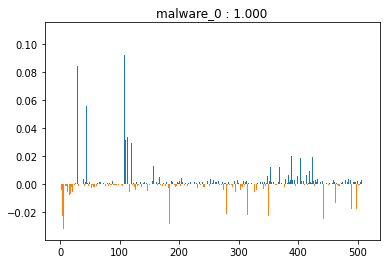

0a677fb789978cdd22f6c0c66a5cf01a9e2fd6d9fcb6484b2385d9354f0632f2.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 8.078


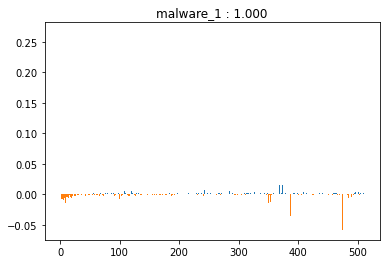

0a711ca925166cadd3c73802b3ba569bf6a6f951fded4c60ccc6ecc2c756473d.dat.json

[!!!] Probability of being malicious: 0.532 | Logit: 0.126


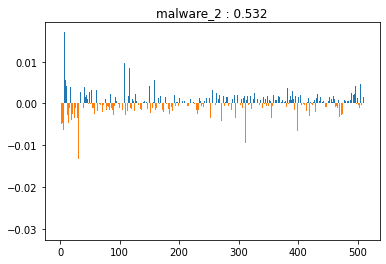

0afa6b5d80f2f3a56c9144d2033b3ea168abb86bbe5e26bc71eccbcf8a0be93a.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 9.343


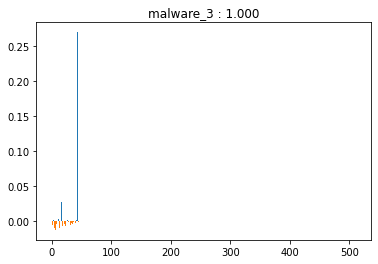

0b1e9a9d060e20685b2718d0a6667e76459ca141ea062b883873ceaa16afb5d9.dat.json

[!!!] Probability of being malicious: 0.596 | Logit: 0.387


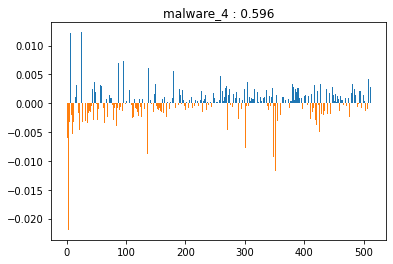

0b30e9492b3d43bddf9be4d2f29441f2318b2958e37cfda8efc07f5257c949c9.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 29.867


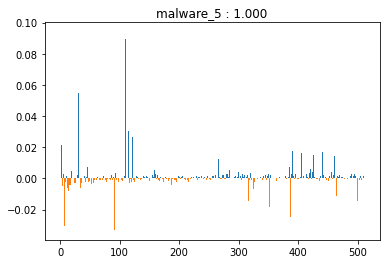

0b6a25fdef6575f6aea7941c63a8a0a740a6754acae7d32f5a590dcae01d27fc.dat.json

[!!!] Probability of being malicious: 1.000 | Logit: 25.289


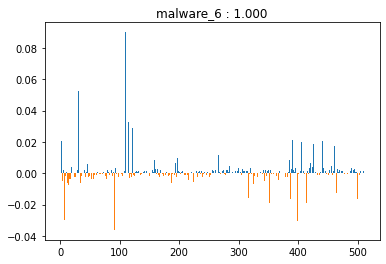

0b6c3923a7d34f3062dab70853887a2a3c8bdb009e9a110d4a554bef892b26fd.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -13.090


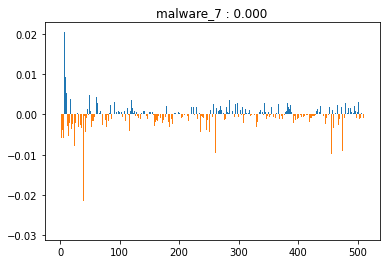


[!!!] GOODWARE FOLDER
0a0ba23720d5afda91ccb93bda9e560473cce055bf2f516d36cc23a9c3a42e60.dat.json

[!!!] Probability of being malicious: 0.259 | Logit: -1.049


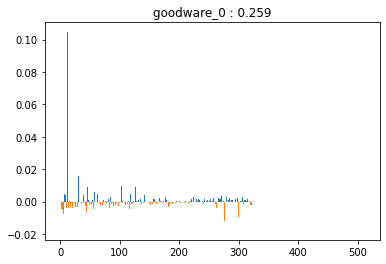

0a1e8fd4416c21fa74171048a53eaeeb958d77b1c44986633110c01c0c91b38e.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -7.818


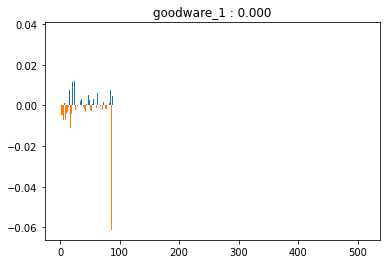

0a2b0354ac9b5ec2967412f0577f2f803b93693283101b417eba342ce1205eaa.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -19.025


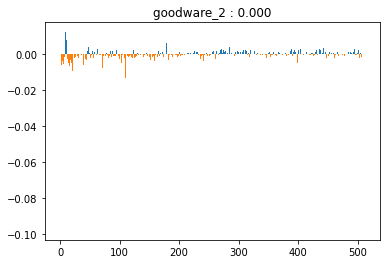

0a3bbeb27e09ef22c94f7440d07bedde479e0e9f122fe51b6f86b4634120221b.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -9.864


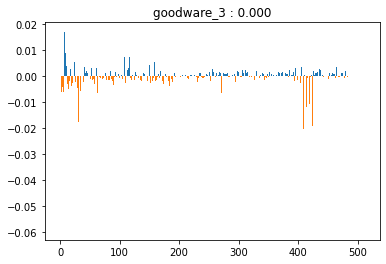

0a4a72fe3cc032f6270ffbd460bb1e68ef005795334e3e478e95965469591681.dat.json

[!!!] Probability of being malicious: 0.024 | Logit: -3.689


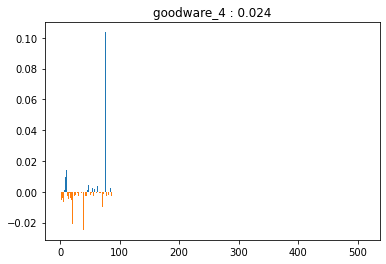

0a4e5a5bb11126116ea610019c1ec5ee5d3a3312dfa1975f94acc13eb1545d58.dat.json

[!!!] Probability of being malicious: 0.000 | Logit: -10.553


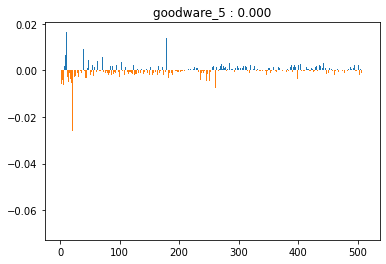

0a57cc32471142bd98fd1aa1004826a03edfef99698d990cd4c5a746c78a65ff.dat.json

[!!!] Probability of being malicious: 0.048 | Logit: -2.998


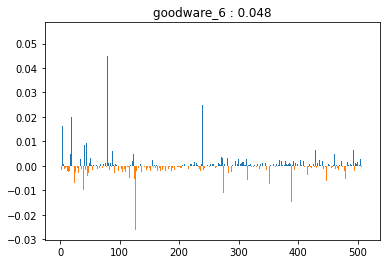

0a5efb412ca54bce23961cef891c28e0e76a5bef2aa776f35374f4d7bfec9aa5.dat.json

[!!!] Probability of being malicious: 0.001 | Logit: -6.535


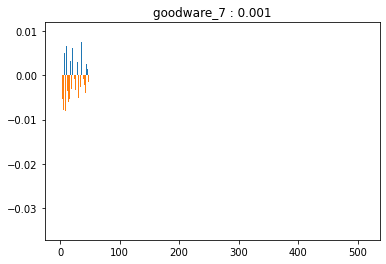

In [2]:
x_baseline = tokenize_sample(baseline_report)
x_embed_baseline = embed(model, baseline_report)

print(f"\n[!!!] MALWARE FOLDER")
filepaths, explanations = analyse_folder(malware_folder, model_no_embed, x_embed_baseline, "malware")

print(f"\n[!!!] GOODWARE FOLDER")
_ = analyse_folder(goodware_folder, model_no_embed, x_embed_baseline, "goodware")

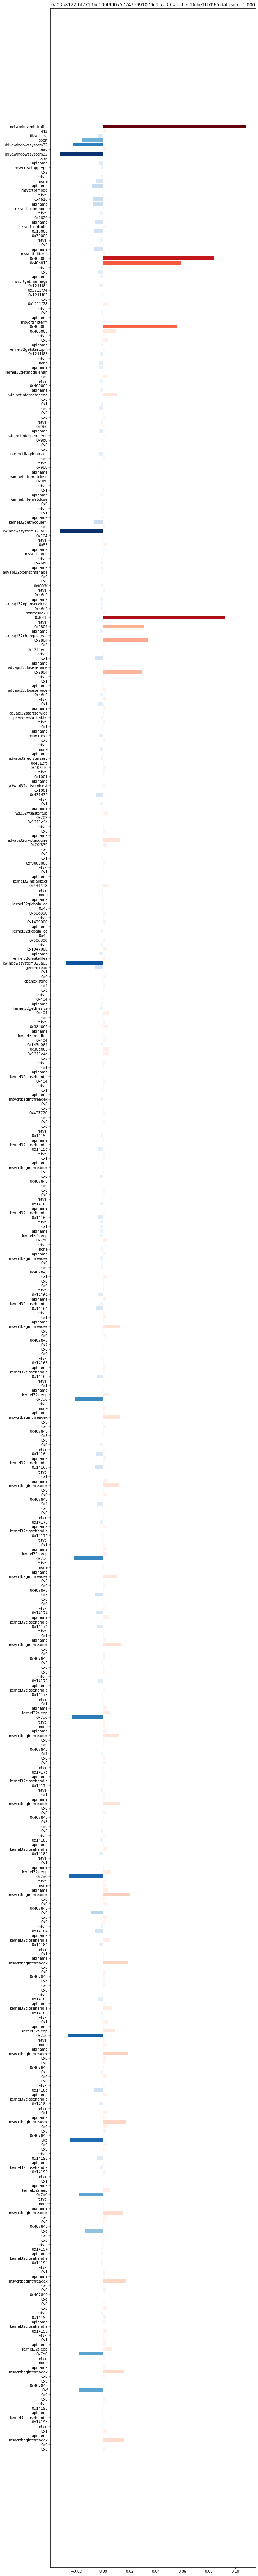

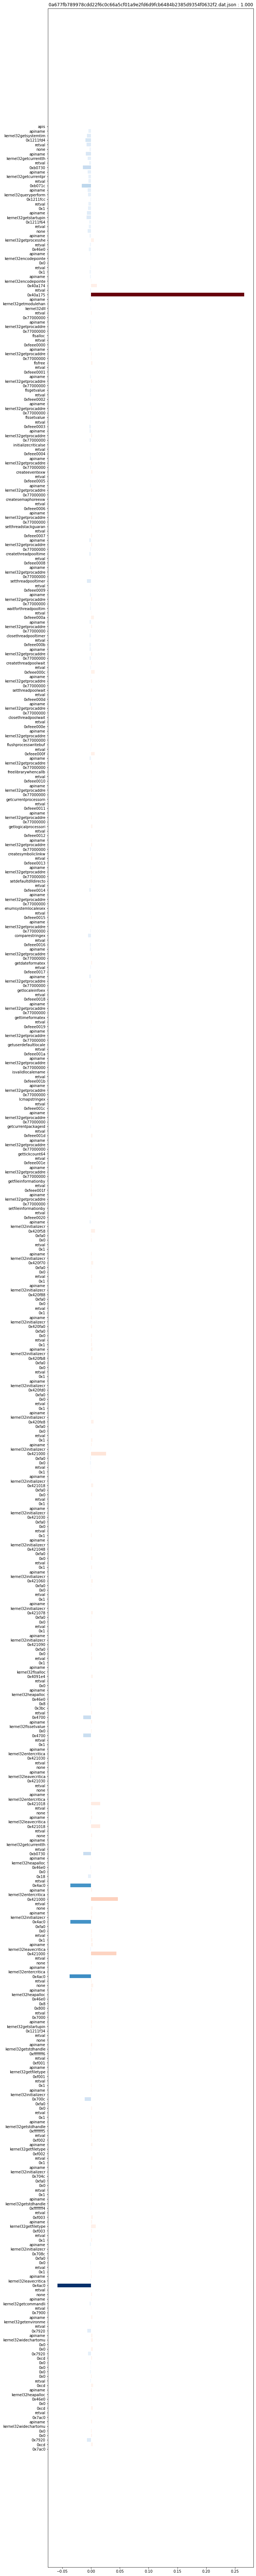

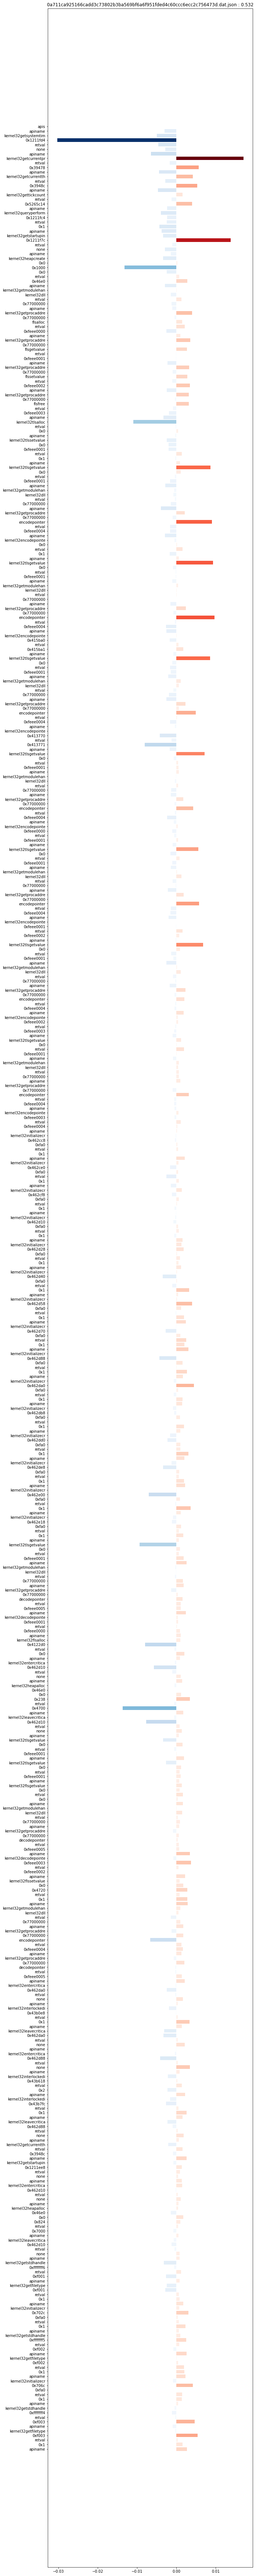

In [3]:
def plot_importance(filepaths, explanations, idx=None, start=0, end=100, token_max_len=20):
    """
    It should plot the string values along y-axis and plot bars
    with length and color equal to the float values in red/orange heatmap colorscheme.
    """
    if idx is None:
        idxs = range(len(filepaths))
    else:
        idxs = [idx]
    for idx in idxs:
        sample_values = explanations[idx].mean(axis=2)[:,start:end][0].tolist()[::-1]
        sample_tokens = tokenize_sample(os.path.join(malware_folder, filepaths[idx]), encode=False)
        sample_tokens = sample_tokens[start:end][::-1]
        # limit length of every element in sample tokens to max 15 chars
        sample_tokens = [token[:token_max_len] for token in sample_tokens]

        ysize = len(sample_tokens) * 0.25
        fig, ax = plt.subplots(figsize=(10, ysize))
        x = range(len(sample_tokens))    
        # assign color to each bar based on value:
        # -- the higher value, the more red
        # -- if value is below 0, then use blue instead of red
        colors = []
        mmax = max(sample_values)
        mmin = min(sample_values)
        for value in sample_values:
            if value > 0:
                c = plt.cm.Reds(value / mmax)
            else:
                c = plt.cm.Blues(value / mmin)
            colors.append(c)
        plt.barh(x, sample_values, color=colors)
        plt.yticks(x, sample_tokens)

        # compute_score
        x = tokenize_sample(os.path.join(malware_folder, filepaths[idx]))
        prob = compute_score(model, x, verbose=False)
        plt.title(f"{filepaths[idx]} : {prob:.3f}")

plot_importance( # just first 3 samples for now
    filepaths=filepaths[0:3],
    explanations=explanations[0:3],
    idx=None,
    end=512
)